### Monte Carlo Tree Search + AlphaZero

In [52]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)

import matplotlib.pyplot as plt

from tqdm.notebook import trange

import random

##### Game of tic tac toe

In [48]:
class TicTacToe:
    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count # all possible actions
        
    def __repr__(self):
        return 'TicTacToe'
        
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player
        return state
    
    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False
        
        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]
        
        return (
            np.sum(state[row, :]) == player * self.column_count # win in a row
            or np.sum(state[:, column]) == player * self.row_count # win in a coulmn
            or np.sum(np.diag(state)) == player * self.row_count # win in the first diagonal
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count # win in the second diagonal
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True # a win
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True # a draw
        return 0, False # other
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state): # for the model
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

##### human vs human

In [3]:
tictactoe = TicTacToe()
player = 1
state = tictactoe.get_initial_state()

while True:
    print(state)
    valid_moves = tictactoe.get_valid_moves(state)
    print("valid_moves", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
    action = int(input(f'{player}:'))
    
    if valid_moves[action] == 0:
        print('action not valid')
        continue
    
    state = tictactoe.get_next_state(state, action, player)
    
    value, is_terminal = tictactoe.get_value_and_terminated(state, action)
    
    if is_terminal:
        print(state)
        if value == 1:
            print(player, 'won')
        else:
            print('draw')
        break
        
    player = tictactoe.get_opponent(player)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6, 7, 8]
1:0
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
valid_moves [1, 2, 3, 4, 5, 6, 7, 8]
-1:1
[[ 1. -1.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
valid_moves [2, 3, 4, 5, 6, 7, 8]
1:2
[[ 1. -1.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
valid_moves [3, 4, 5, 6, 7, 8]
-1:3
[[ 1. -1.  1.]
 [-1.  0.  0.]
 [ 0.  0.  0.]]
valid_moves [4, 5, 6, 7, 8]
1:4
[[ 1. -1.  1.]
 [-1.  1.  0.]
 [ 0.  0.  0.]]
valid_moves [5, 6, 7, 8]
-1:1
action not valid
[[ 1. -1.  1.]
 [-1.  1.  0.]
 [ 0.  0.  0.]]
valid_moves [5, 6, 7, 8]
-1:6
[[ 1. -1.  1.]
 [-1.  1.  0.]
 [-1.  0.  0.]]
valid_moves [5, 7, 8]
1:8
[[ 1. -1.  1.]
 [-1.  1.  0.]
 [-1.  0.  1.]]
1 won


##### Node for MCTS

In [ ]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        
        self.children = []
        self.expandable_moves = game.get_valid_moves(state)
        
        self.visit_count = 0
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return np.sum(self.expandable_moves) == 0 and len(self.children) > 0
    
    def select(self): # get the most promising child
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2 # value between 0 and 1
        return q_value + self.args['C'] * np.sqrt(np.log(self.visit_count) / child.visit_count)
    
    def expand(self):
        # pick a random legal action
        action = np.random.choice(np.where(self.expandable_moves == 1)[0])
        self.expandable_moves[action] = 0
        
        # get a child state given an action
        child_state = self.state.copy()
        child_state = self.game.get_next_state(child_state, action, 1)
        child_state = self.game.change_perspective(child_state, player=-1) # we need to switch the perspective
        
        # create the node
        child = Node(self.game, self.args, child_state, self, action)
        # add to the children
        self.children.append(child)
        
        return child
    
    def simulate(self):
        # check if we are in the terminal state
        value, is_terminal = self.game.get_value_and_terminated(self.state, self.action_taken)
        value = self.game.get_opponent_value(value)
        
        # if we are in the terminal state return expected value
        if is_terminal:
            return value
        
        # simulate until we reach terminal state
        rollout_state = self.state.copy()
        rollout_player = 1
        while True:
            # pick a random legal action
            valid_moves = self.game.get_valid_moves(rollout_state)
            action = np.random.choice(np.where(valid_moves == 1)[0])
            
            # get a child state given an action
            rollout_state = self.game.get_next_state(rollout_state, action, rollout_player)
            
            # check if we are in the terminal state
            value, is_terminal = self.game.get_value_and_terminated(rollout_state, action)
            
            # if we are in the terminal state return expected value
            if is_terminal:
                if player == -1:
                    value = self.game.get_opponent_value(value) # we need to switch the perspective if opponent won
                return value
            
            rollout_player = self.game.get_opponent(rollout_player)
            
    def backpropagate(self, value):
        # update values
        self.value_sum += value
        self.visit_count += 1
        
        # flip the value for the parent
        value = self.game.get_opponent_value(value)
        
        # update the parent
        if self.parent is not None:
            self.parent.backpropagate(value)

##### Monte Carlo Tree Search

In [5]:
class MCTS:
    def __init__(self, game, args):
        self.game = game
        self.args = args
        
    def search(self, state):
        # make a root
        root = Node(self.game, self.args, state)
        
        for search in range(self.args['num_searches']):
            node = root
            
            # find the best not expanded node
            while node.is_fully_expanded():
                node = node.select()
                
            # check if the node is terminal
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            # if not terminal, expand the node + simulate the resut
            if not is_terminal:
                node = node.expand()
                value = node.simulate()
            
            # update the values
            node.backpropagate(value)
            
        
        # calculate probabilities for children
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        
        return action_probs

##### ResBlock for ResNet

In [11]:
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

##### ResNet for AlphaZero

In [28]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden):
        super().__init__()
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backbone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size),
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backbone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value

##### Node for AlphaMCTS

In [56]:
class AlphaNode:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        
        self.children = []
        
        self.visit_count = visit_count
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self): # get the most promising child
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2 # value between 0 and 1
        return q_value + self.args['C'] * (np.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior # include prior
    
    def expand(self, policy):
        # expand all children at the same time
        for action, prob in enumerate(policy):
            # expand only legal moves
            if prob > 0:
                 # get a child state given an action
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                # create the node
                child = AlphaNode(self.game, self.args, child_state, self, action, prob)
                # add to the children
                self.children.append(child) 
    
            
    def backpropagate(self, value):
        # update values
        self.value_sum += value
        self.visit_count += 1
        
        # flip the value for the parent
        value = self.game.get_opponent_value(value)
        
        # update the parent
        if self.parent is not None:
            self.parent.backpropagate(value)

##### AlphaMCTS

In [57]:
class AlphaMCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
        
    @torch.no_grad()
    def search(self, state):
        # make a root
        root = AlphaNode(self.game, self.args, state)
        
        # get the policy from the model accoriding to the state
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state)).unsqueeze(0)
        )
        
        # apply softmax
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        
        # add noise
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)
        
        # remove illegal moves
        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        
        # make sure probabilities add up to 1
        policy /= np.sum(policy)
        
        # expand the root with policy
        root.expand(policy)
        
        
        for search in range(self.args['num_searches']):
            node = root
            
            # find the best not expanded node
            while node.is_fully_expanded():
                node = node.select()
                
            # check if the node is terminal
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            # if not terminal, expand the node
            if not is_terminal:
                # get policy and value from the model
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
                )
                
                # apply softmax on policy
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                
                # remove illegal moves
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                
                # make sure probabilities add up to 1
                policy /= np.sum(policy)
            
                # get numerical value
                value = value.item()
                
                # expand the node with policy
                node.expand(policy)
            
            # update the values
            node.backpropagate(value)
            
        
        # calculate probabilities for children
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        
        return action_probs

##### AlphaZero

In [58]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.aplhaMCTS = AlphaMCTS(game, args, model)
        
    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()
        
        while True:
            # get neutral state
            neutral_state = self.game.change_perspective(state, player)
            
            # get actions distribution form AlphaMCTS
            action_probs = self.aplhaMCTS.search(neutral_state)
            
            # add state, probabilities and player to the memory 
            memory.append((neutral_state, action_probs, player))
            
            # perform an random weighted action from actions distribution
            action = np.random.choice(self.game.action_size, p=action_probs)
            
            # get the state after the action
            state = self.game.get_next_state(state, action, player)
            
            # check if the state is terminal
            value, is_terminal = self.game.get_value_and_terminated(state, action)
            
            if is_terminal:
                # what will be returned
                returnMemory = []
                
                # for every example in memory
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    # calculate the final outcome 
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    
                    # add encoded state, action probabilities and final outcome to the returned memory
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            
            # if not terminal, change the player
            player = self.game.get_opponent(player)
    
    def train(self, memory):
        # shuffle memory
        random.shuffle(memory)
        
        # for every batch
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            
            # get the batch
            batch = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            
            # get the state and approppriate targets
            state, policy_targets, value_targets = zip(*batch)
            
            # convert to torch tensors
            state = torch.tensor(np.array(state), dtype=torch.float32)
            policy_targets = torch.tensor(np.array(policy_targets), dtype=torch.float32)
            value_targets = torch.tensor(np.array(value_targets).reshape(-1, 1), dtype=torch.float32)
            
            # get results from the model
            out_policy, out_value = self.model(state)
            
            # calulate the loss between expected targets and results from the model
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            # backpropagation
            self.optimizer.zero_grad() 
            loss.backward()
            self.optimizer.step()
            
    
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            # where we will store games from self play
            memory = []
            
            # switch model to eval mode
            self.model.eval()
            # self play to generate data
            for selfPlayIteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()
                
            # switch model to train mode
            self.model.train()
            # train model with data from self play
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            # save model and optimizer after each iteration
            torch.save(self.model.state_dict(), f'model_{iteration}_{self.game}.pt')
            torch.save(self.optimizer.state_dict(), f'optimizer_{iteration}_{self.game}.pt')

##### train the model

In [68]:
tictactoe = TicTacToe()

model = ResNet(tictactoe, 4, 64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_searches': 32,
    'num_iterations': 3,
    'num_selfPlay_iterations': 100,
    'num_epochs': 4,
    'batch_size': 32,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphaZero = AlphaZero(model, optimizer, tictactoe, args)
alphaZero.learn()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

##### test

0.6866602301597595
[[ 0.  0. -1.]
 [ 0. -1.  0.]
 [ 1.  0.  1.]]
tensor([[[[0., 0., 1.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[1., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [1., 0., 1.]]]])


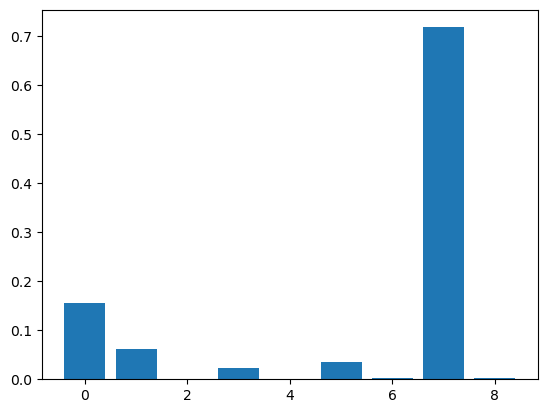

In [70]:
tictactoe = TicTacToe()

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, -1)
state = tictactoe.get_next_state(state, 4, -1)
state = tictactoe.get_next_state(state, 6, 1)
state = tictactoe.get_next_state(state, 8, 1)


encoded_state = tictactoe.get_encoded_state(state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(tictactoe, 4, 64)
model.load_state_dict(torch.load('model_2_TicTacToe.pt'))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)

print(state)
print(tensor_state)

plt.bar(range(tictactoe.action_size), policy)
plt.show()

In [73]:
tictactoe = TicTacToe()
player = 1

args = {
    'C': 2,
    'num_searches': 32,
    'num_iterations': 3,
    'num_selfPlay_iterations': 100,
    'num_epochs': 4,
    'batch_size': 32,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

model = ResNet(tictactoe, 4, 64)
model.load_state_dict(torch.load('model_2_TicTacToe.pt'))
model.eval()

mcts = AlphaMCTS(tictactoe, args, model)

state = tictactoe.get_initial_state()


while True:
    print(state)
    
    if player == 1:
        valid_moves = tictactoe.get_valid_moves(state)
        print("valid_moves", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))

        if valid_moves[action] == 0:
            print("action not valid")
            continue
            
    else:
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)
        
    state = tictactoe.get_next_state(state, action, player)
    
    value, is_terminal = tictactoe.get_value_and_terminated(state, action)
    
    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break
        
    player = tictactoe.get_opponent(player)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6, 7, 8]
1:4
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]
valid_moves [0, 1, 2, 3, 5, 7, 8]
1:1
[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]
[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [-1. -1.  0.]]
valid_moves [0, 2, 3, 5, 8]
1:8
[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [-1. -1.  1.]]
[[-1.  1.  0.]
 [ 0.  1.  0.]
 [-1. -1.  1.]]
valid_moves [2, 3, 5]
1:3
[[-1.  1.  0.]
 [ 1.  1.  0.]
 [-1. -1.  1.]]
[[-1.  1.  0.]
 [ 1.  1. -1.]
 [-1. -1.  1.]]
valid_moves [2]
1:2
[[-1.  1.  1.]
 [ 1.  1. -1.]
 [-1. -1.  1.]]
draw
